> CIFAR10 dataset has 10 classes - ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

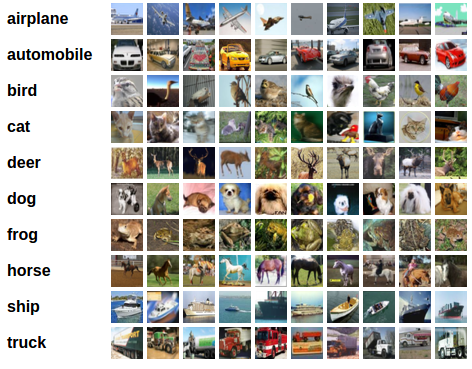

# Selecting device

In [1]:
import torch 

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Loading and normalizing images using TorchVision


In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71276398.71it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Displaying some images

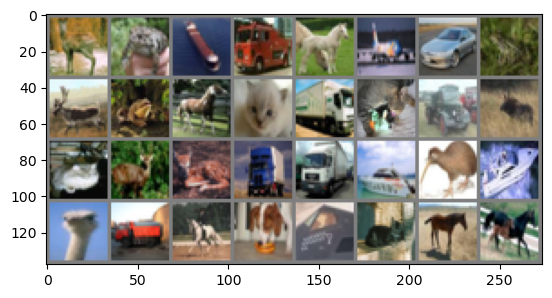

 deer  frog  ship truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.bn1 = nn.BatchNorm2d(256).to(device)
        self.conv2 = nn.Conv2d(256, 512, 3).to(device)
        self.bn2 = nn.BatchNorm2d(512).to(device)
        self.conv3 = nn.Conv2d(512, 1024, 3).to(device)
        self.bn3 = nn.BatchNorm2d(1024).to(device)
        self.fc1 = nn.Linear(1024 * 2 * 2, 2048).to(device)
        self.fc2 = nn.Linear(2048, 512).to(device)
        self.fc3 = nn.Linear(512, 10).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)).to(device))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)).to(device))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)).to(device))
        x = self.bn3(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1).to(device)
        return x


net = Net()

In [6]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 6912
conv1.bias 	 256
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402


# Now we will load our model

In [7]:
PATH = '/kaggle/input/d/riddhic777/unpruned-model/cifar_net.pth'

net1 = Net() #Unpruned model
net2 = Net() #Random Unstructured Pruning
net3 = Net() #L1 Unstructured Pruning
net4 = Net() #Random Structured Pruning
net5 = Net() #Ln Structured Pruning
net6 = Net() #Pruning multiple parameters
net7 = Net() #Global Pruning
net8 = Net() #Custom Pruning

net1.load_state_dict(torch.load(PATH))
net2.load_state_dict(torch.load(PATH))
net3.load_state_dict(torch.load(PATH))
net4.load_state_dict(torch.load(PATH))
net5.load_state_dict(torch.load(PATH))
net6.load_state_dict(torch.load(PATH))
net7.load_state_dict(torch.load(PATH))
net8.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Pruning the model

In [8]:
import torch.nn.utils.prune as prune

## Inspecting the conv1 layer

In [9]:
module = net1.conv1
#print(list(module.named_parameters()))

In [10]:
#print(list(module.named_buffers()))

## Random Unstructured Pruning

**Randomly prune 40% of the connections in the parameter named weight**

In [11]:
module = net2.conv1
prune.random_unstructured(module, name="weight", amount=0.4)
prune.random_unstructured(module, name="bias", amount=0.4)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

**The pruning mask:**

In [12]:
#print(list(module.named_buffers()))

**weight is now an just an attribute of the module**

In [13]:
#print(module.weight)

In [14]:
print(module._forward_pre_hooks)

OrderedDict([(0, <torch.nn.utils.prune.RandomUnstructured object at 0x78fb31290850>), (1, <torch.nn.utils.prune.RandomUnstructured object at 0x78fb312908e0>)])


## L1 Unstructured Pruning

**Prune 40% of entries based on minimum L1 norm**

In [15]:
module = net3.conv1
prune.l1_unstructured(module, name="weight", amount=0.4)
prune.l1_unstructured(module, name="bias", amount=0.4)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [16]:
print(module._forward_pre_hooks)

OrderedDict([(2, <torch.nn.utils.prune.L1Unstructured object at 0x78fb31293d60>), (3, <torch.nn.utils.prune.L1Unstructured object at 0x78fb31290c40>)])


## Random Structured Pruning

**Prune 41.479% of the channels**

In [17]:
module = net4.conv1
prune.random_structured(module, name="weight", amount=0.41479, dim=0)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [18]:
print(module._forward_pre_hooks)

OrderedDict([(4, <torch.nn.utils.prune.RandomStructured object at 0x78fb31293190>)])


## Ln Structured Pruning

**Pruning 41.479% of the channels based on the channels' L1 norm**

In [19]:
module = net5.conv1
prune.ln_structured(module, name="weight", amount=0.41479, n=1, dim=0)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [20]:
print(module._forward_pre_hooks)

OrderedDict([(5, <torch.nn.utils.prune.LnStructured object at 0x78fb3129eb00>)])


## Pruning multiple parameters in the model

**Using l1_unstructured, prune 30% of connections in all Conv2D layers and prune 40% of the connections in all Linear layers**

In [21]:
for name, module in net6.named_modules():
    # prune 30% of connections in all Conv2D layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.3)
        prune.l1_unstructured(module, name='bias', amount=0.3)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)
        prune.l1_unstructured(module, name='bias', amount=0.4)

print(dict(net6.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['conv1.weight_mask', 'conv1.bias_mask', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight_mask', 'conv2.bias_mask', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight_mask', 'conv3.bias_mask', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'fc1.weight_mask', 'fc1.bias_mask', 'fc2.weight_mask', 'fc2.bias_mask', 'fc3.weight_mask', 'fc3.bias_mask'])


## Global Pruning

**Pruning 75% of connections across the whole model based on lowest L1 norm**

In [22]:
parameters_to_prune = (
    (net7.conv1, 'weight'),
    (net7.bn1, 'weight'),
    (net7.conv2, 'weight'),
    (net7.bn2, 'weight'),
    (net7.conv3, 'weight'),
    (net7.bn3, 'weight'),
    (net7.fc1, 'weight'),
    (net7.fc2, 'weight'),
    (net7.fc3, 'weight'),
    (net7.conv1, 'bias'),
    (net7.bn1, 'bias'),
    (net7.conv2, 'bias'),
    (net7.bn2, 'bias'),
    (net7.conv3, 'bias'),
    (net7.bn3, 'bias'),
    (net7.fc1, 'bias'),
    (net7.fc2, 'bias'),
    (net7.fc3, 'bias')
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.75,
)

Now we can check the sparsity induced in every pruned parameter, which will not be equal to 20% in each layer. However, the global sparsity will be (approximately) 20%.

In [23]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv1.weight == 0))
        / float(net7.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv2.weight == 0))
        / float(net7.conv2.weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.conv3.weight == 0))
        / float(net7.conv3.weight.nelement())
    )
)
print(
    "Sparsity in bn1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn1.weight == 0))
        / float(net7.bn1.weight.nelement())
    )
)
print(
    "Sparsity in bn2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn2.weight == 0))
        / float(net7.bn2.weight.nelement())
    )
)
print(
    "Sparsity in bn3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.bn3.weight == 0))
        / float(net7.bn3.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc1.weight == 0))
        / float(net7.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc2.weight == 0))
        / float(net7.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net7.fc3.weight == 0))
        / float(net7.fc3.weight.nelement())
    )
)
print(
    "Sparsity in conv1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv1.bias == 0))
        / float(net7.conv1.bias.nelement())
    )
)
print(
    "Sparsity in conv2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv2.bias == 0))
        / float(net7.conv2.bias.nelement())
    )
)
print(
    "Sparsity in conv3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.conv3.bias == 0))
        / float(net7.conv3.bias.nelement())
    )
)
print(
    "Sparsity in bn1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn1.bias == 0))
        / float(net7.bn1.bias.nelement())
    )
)
print(
    "Sparsity in bn2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn2.bias == 0))
        / float(net7.bn2.bias.nelement())
    )
)
print(
    "Sparsity in bn3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.bn3.bias == 0))
        / float(net7.bn3.bias.nelement())
    )
)
print(
    "Sparsity in fc1.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc1.bias == 0))
        / float(net7.fc1.bias.nelement())
    )
)
print(
    "Sparsity in fc2.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc2.bias == 0))
        / float(net7.fc2.bias.nelement())
    )
)
print(
    "Sparsity in fc3.bias: {:.2f}%".format(
        100. * float(torch.sum(net7.fc3.bias == 0))
        / float(net7.fc3.bias.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(net7.conv1.weight == 0)
            + torch.sum(net7.conv2.weight == 0)
            + torch.sum(net7.conv3.weight == 0)
            + torch.sum(net7.bn1.weight == 0)
            + torch.sum(net7.bn2.weight == 0)
            + torch.sum(net7.bn3.weight == 0)
            + torch.sum(net7.fc1.weight == 0)
            + torch.sum(net7.fc2.weight == 0)
            + torch.sum(net7.fc3.weight == 0)
            + torch.sum(net7.conv1.bias == 0)
            + torch.sum(net7.conv2.bias == 0)
            + torch.sum(net7.conv3.bias == 0)
            + torch.sum(net7.bn1.bias == 0)
            + torch.sum(net7.bn2.bias == 0)
            + torch.sum(net7.bn3.bias == 0)
            + torch.sum(net7.fc1.bias == 0)
            + torch.sum(net7.fc2.bias == 0)
            + torch.sum(net7.fc3.bias == 0)
        )
        / float(
            net7.conv1.weight.nelement()
            + net7.conv2.weight.nelement()
            + net7.conv3.weight.nelement()
            + net7.bn1.weight.nelement()
            + net7.bn2.weight.nelement()
            + net7.bn3.weight.nelement()
            + net7.fc1.weight.nelement()
            + net7.fc2.weight.nelement()
            + net7.fc3.weight.nelement()
            +net7.conv1.bias.nelement()
            + net7.conv2.bias.nelement()
            + net7.conv3.bias.nelement()
            + net7.bn1.bias.nelement()
            + net7.bn2.bias.nelement()
            + net7.bn3.bias.nelement()
            + net7.fc1.bias.nelement()
            + net7.fc2.bias.nelement()
            + net7.fc3.bias.nelement()
        )
    )
)

Sparsity in conv1.weight: 16.23%
Sparsity in conv2.weight: 72.81%
Sparsity in conv3.weight: 74.64%
Sparsity in bn1.weight: 0.00%
Sparsity in bn2.weight: 0.00%
Sparsity in bn3.weight: 0.00%
Sparsity in fc1.weight: 75.54%
Sparsity in fc2.weight: 75.71%
Sparsity in fc3.weight: 51.15%
Sparsity in conv1.bias: 16.80%
Sparsity in conv2.bias: 4.49%
Sparsity in conv3.bias: 3.42%
Sparsity in bn1.bias: 5.08%
Sparsity in bn2.bias: 7.81%
Sparsity in bn3.bias: 31.25%
Sparsity in fc1.bias: 5.81%
Sparsity in fc2.bias: 92.77%
Sparsity in fc3.bias: 70.00%
Global sparsity: 75.00%


## Custom Pruning

**A pruning technique that prunes every other entry in a tensor (or – if the tensor has previously been pruned – in the remaining unpruned portion of the tensor). This will be of PRUNING_TYPE='unstructured' because it acts on individual connections in a layer and not on entire units/channels ('structured'), or across different parameters ('global').**

In [24]:
class CustomPruningMethod(prune.BasePruningMethod):
    """Prune every other entry in a tensor
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        mask.view(-1)[::2] = 0
        return mask
    
def custom_unstructured(module, name):
    CustomPruningMethod.apply(module, name)
    return module

In [25]:
custom_unstructured(net8.conv1, name='weight')
custom_unstructured(net8.conv1, name='bias')

print(net8.conv1.weight_mask)
print(net8.conv1.bias_mask)

tensor([[[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]],


        [[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]],


        ...,


        [[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[1., 

# Let's test the accuracy of the model

In [26]:
net = net5   # LOAD THE MODEL TO BE TESTED

total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

total_params = 0
pruned_params = 0

flag = 0
for name, module in net.named_modules():
    if flag == 0:
        flag = 1 
        continue
    try:
        total_params += module.weight.nelement()
        total_params += module.bias.nelement()
        
        pruned_params += torch.sum(module.weight == 0).item()
        pruned_params += torch.sum(module.bias == 0).item()
    except AttributeError:
        pass
    
print("")
print("Parameters pruned: "+str(pruned_params))
print("Remaining parameters: "+str(total_params - pruned_params))
print("Total parameters: "+str(total_params))

Trainable parameters:
conv1.bias 	 256
conv1.weight_orig 	 6912
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402

Parameters pruned: 2862
Remaining parameters: 15352540
Total parameters: 15355402


**Displaying an image from test set**

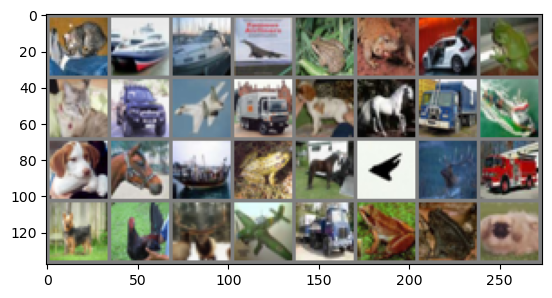

GroundTruth:    cat  ship  ship plane


In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

**We will now see how the neural network predicts the above image**

In [28]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)

**The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:**

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


**Let us look at how the network performs on the whole dataset.**

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


**Let's see which classes performed well individually**

In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 85 %
Accuracy of  bird : 72 %
Accuracy of   cat : 55 %
Accuracy of  deer : 70 %
Accuracy of   dog : 69 %
Accuracy of  frog : 85 %
Accuracy of horse : 75 %
Accuracy of  ship : 87 %
Accuracy of truck : 88 %
